# `CLOUD.jl` - 2D linear advection

In [1]:
using CLOUD
using OrdinaryDiffEq
using LinearAlgebra
using TimerOutputs
plots_path = "../plots/advection_collapsed_2D_skew_p4M4_linear_test/"
results_path = "../results/advection_collapsed_2D_skew_p4M4_test/";

Define the physical problem

In [2]:
θ = π/4
a = sqrt(2)
A = 1.0  # amplitude
L = 1.0  # domain length
k = (2*π/L, 2*π/L)  # wave number
T = 1.0/(a*max(abs(cos(θ)),abs(cos(θ))))  # end time
initial_data = InitialDataSine(A,k)
conservation_law = linear_advection_equation((a*cos(θ),a*sin(θ)),λ=1.0);

Set up a collapsed-edge scheme of degree `p` with `M` intervals in each direction

Set plotting and post-processing options

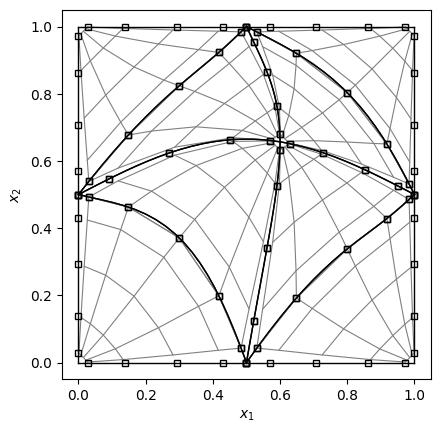

In [3]:
M = 2
p = 4
p_map = p+1
form = SplitConservationForm()
mesh_strategy = ZigZag()
strategy=Lazy()

reference_approximation =ReferenceApproximation(
    CollapsedModal(p), Tri(),
    volume_quadrature_rule=(LGQuadrature(),LGRQuadrature()),
    facet_quadrature_rule=(LGQuadrature(),LGRQuadrature()), 
    chain_rule_diff=true, mapping_degree=p_map,
    N_plot=ceil(Int,50/M));
mesh = warp_mesh(uniform_periodic_mesh(
    reference_approximation.reference_element, 
    ((0.0,L),(0.0,L)), (M,M), strategy=mesh_strategy), 
    reference_approximation.reference_element, 0.1)
spatial_discretization = SpatialDiscretization(mesh, 
    reference_approximation);
solver = Solver(conservation_law, spatial_discretization, form, strategy)
results_path = save_project(conservation_law,
     spatial_discretization, initial_data, form, 
     (0.0, T), strategy, results_path, overwrite=true, clear=true)
visualize(spatial_discretization, plots_path, "mesh.pdf", 
    grid_lines=true, plot_volume_nodes=false, geometry_resolution=20)

In [4]:
error_analysis = ErrorAnalysis(results_path, conservation_law, 
    spatial_discretization)
conservation_analysis = PrimaryConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)
energy_analysis = EnergyConservationAnalysis(results_path, 
    conservation_law, spatial_discretization)

tol = 1.0e-12
n_s = prod(get_dof(spatial_discretization,conservation_law))
r = n_s-2
linear_analysis = LinearAnalysis(results_path, conservation_law, spatial_discretization,
    LinearResidual(solver), r=r, tol=tol)
plotter = Plotter(spatial_discretization, plots_path);

Run the `OrdinaryDiffEq` solver, taking `n_s` snapshots

In [5]:
dt_scale=0.01
dt = dt_scale*(L/M)/(norm(a)*(2*p+1))
ode_problem = semidiscretize(load_project(results_path)...)
save_solution(ode_problem.u0, 0.0, results_path, 0)
reset_timer!()
sol = solve(ode_problem, Tsit5(), adaptive=false,
    dt=dt, save_everystep=false, 
    callback=save_callback(results_path, ceil(Int, T/(dt*n_s))))
print_timer()
save_solution(last(sol.u), last(sol.t), results_path, "final")

 ────────────────────────────────────────────────────────────────────────────────
                                        Time                    Allocations      
                               ───────────────────────   ────────────────────────
       Tot / % measured:            8.72s /  72.1%           4.38GiB /  92.2%    

 Section               ncalls     time    %tot     avg     alloc    %tot      avg
 ────────────────────────────────────────────────────────────────────────────────
 rhs!                   15.5k    6.28s  100.0%   406μs   4.04GiB  100.0%   274KiB
   eval residual         124k    3.14s   50.0%  25.4μs   2.00GiB   49.6%  17.0KiB
     volume terms        124k    2.17s   34.5%  17.5μs   1.66GiB   41.0%  14.0KiB
     facet terms         124k    447ms    7.1%  3.61μs    205MiB    5.0%  1.70KiB
     mass matrix solve   124k    120ms    1.9%   970ns   68.0MiB    1.6%     576B
   eval flux diff        124k    1.28s   20.3%  10.3μs   1.02GiB   25.3%  8.65KiB
   extrapolate 

Visualize the solution

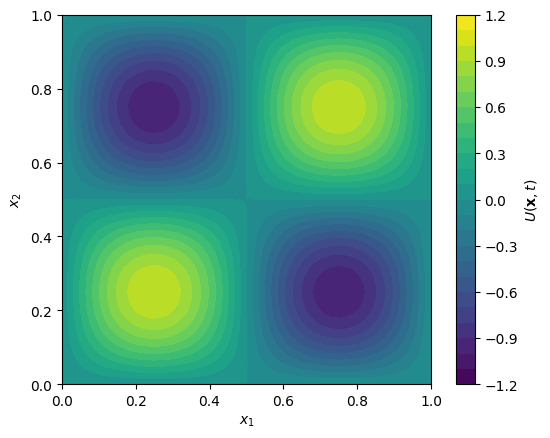

In [6]:
visualize(initial_data, plotter, "exact.pdf", u_range=[-1.0,1.0], contours=25,
    label="U(\\mathbf{x},t)")

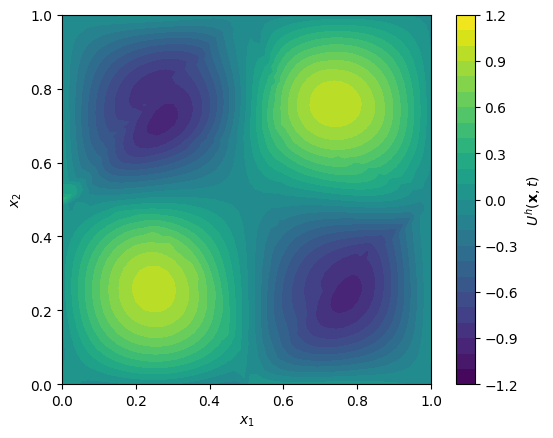

In [7]:
visualize(last(sol.u),plotter, "approx.pdf", contours=25, u_range=[-1.0,1.0],
    label="U^h(\\mathbf{x},t)")

Calculate the integral L<sup>2</sup> error norm and conservation/energy error

In [8]:
println("L2 error:\n", analyze(error_analysis, last(sol.u), initial_data))
println("Conservation (initial/final/diff):\n", analyze(conservation_analysis)...)
println("Energy (initial/final/diff):\n",analyze(energy_analysis)...)

L2 error:
[0.03810573454836303]
Conservation (initial/final/diff):
[-5.859944947805146e-5][-5.8599449477617777e-5][4.3368086899420177e-16]
Energy (initial/final/diff):
[0.24957597294451722][0.23935380520531357][-0.010222167739203647]


In [ ]:
linear_results = analyze(linear_analysis)
plot_spectrum(linear_analysis, linear_results.λ, unit_circle=false, label="\\lambda", numbering=false)